In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from datetime import datetime


In [2]:
data = pd.read_csv('/Users/atharvarane/Downloads/merged_data (1).csv',parse_dates=['ts_event'])

data = data.sort_values('ts_event').reset_index(drop=True)


In [3]:
data.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035


#### Here I calculate the cumulative quantity traded up to each time point and  the time difference in seconds between consecutive events.

In [4]:

data['Cumulative_Q'] = data['Signed Volume'].cumsum()

# Calculate incremental trade (dQ)
data['dQ'] = data['Signed Volume']

# Calculate time difference in seconds between consecutive events
data['delta_t'] = data['ts_event'].diff().dt.total_seconds().fillna(0)



In [5]:
data.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price,Cumulative_Q,dQ,delta_t
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985,-1198.0,-1198.0,0.0
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980,-1199.0,-1.0,1.0
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970,-999.0,200.0,1.0
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030,-865.0,134.0,1.0
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035,-967.0,-102.0,1.0


#### Here we see calculation of the change in the mid-price between consecutive events, representing the immediate price impact.


In [6]:
data['Price_Impact'] = data['mid_price'].diff().fillna(0)
data.head()


,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price,Cumulative_Q,dQ,delta_t,Price_Impact
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985,-1198.0,-1198.0,0.0,0.000
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980,-1199.0,-1.0,1.0,-0.005
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970,-999.0,200.0,1.0,-0.010
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030,-865.0,134.0,1.0,0.060
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035,-967.0,-102.0,1.0,0.005


In [7]:
# Initialize J with zeros
data['J'] = 0.0
data.at[0, 'J'] = 0.0
data.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price,Cumulative_Q,dQ,delta_t,Price_Impact,J
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985,-1198.0,-1198.0,0.0,0.000,0.0
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980,-1199.0,-1.0,1.0,-0.005,0.0
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970,-999.0,200.0,1.0,-0.010,0.0
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030,-865.0,134.0,1.0,0.060,0.0
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035,-967.0,-102.0,1.0,0.005,0.0


- **Exponential Decay**: Implementing the impact decay using:

\[
J_i = e^{-\beta \delta t_i} J_{i-1} + \alpha Q_i
\]


and estimating j and after that using regression to estimate the lambda value


In [18]:
# uisng beta such that it corresponds to price impact of about 2 days so log(2)/2 ( 1/3 rd of a day)
beta= 0.3466

# Compute J with fixed beta
for i in range(1, len(data)):
    dt = data.at[i, 'delta_t']
    decay_factor = np.exp(-beta * dt)
    data.at[i, 'J'] = data.at[i - 1, 'J'] * decay_factor + data.at[i, 'dQ']

# Delta_J
# data['Delta_J'] = data['J'].diff().fillna(0)
# data['y_beta'] = data['Delta_J'] - data['dQ']
# data['X_beta'] = -data['J'] * data['delta_t']

# # Perform regression for lambda estimation using fixed beta
# reg_df_beta = data[data['X_beta'] != 0]
# X_beta = reg_df_beta[['X_beta']].values  # Predictor
# y_beta = reg_df_beta['y_beta'].values  # Response

# reg_beta = LinearRegression()
# reg_beta.fit(X_beta, y_beta)

for i in range(1, len(data)):
    dt = data.at[i, 'delta_t']
    decay_factor = np.exp(-beta * dt)
    data.at[i, 'J'] = (
        data.at[i - 1, 'J'] * decay_factor + data.at[i, 'dQ']
    )

X_lambda = data[['J']].values
y_lambda = data['Price_Impact'].values

reg_lambda = LinearRegression()
reg_lambda.fit(X_lambda, y_lambda)
lambda_estimated = reg_lambda.coef_[0]
print(f"Estimated lambda: {lambda_estimated}")


data['I'] = lambda_estimated * data['J']


Estimated lambda: 7.47197589876434e-08


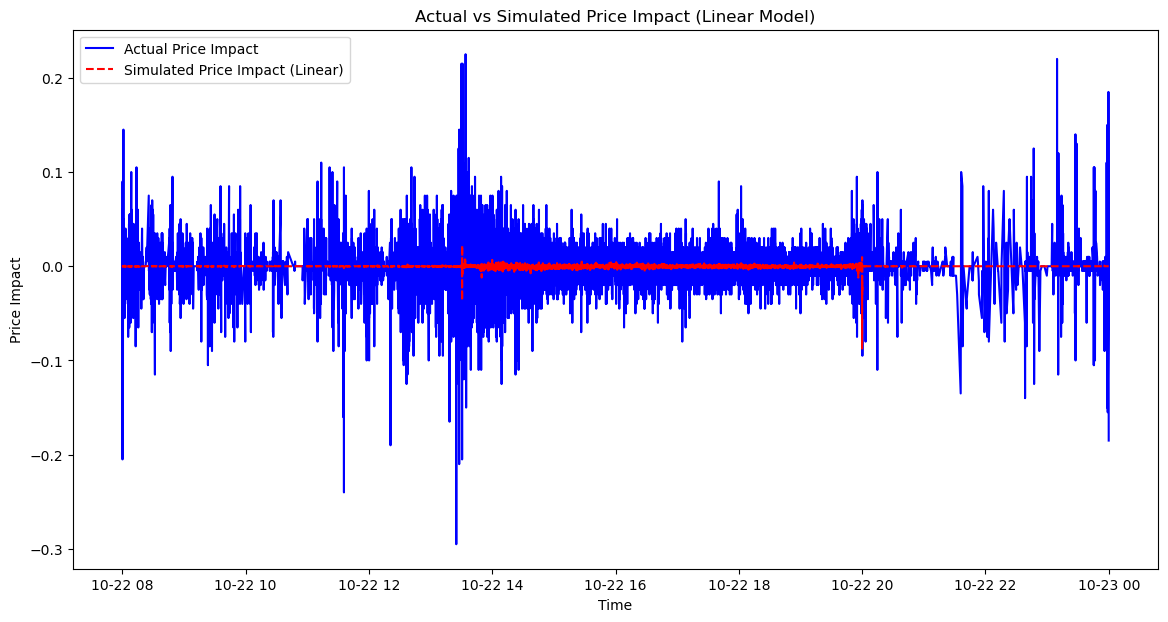

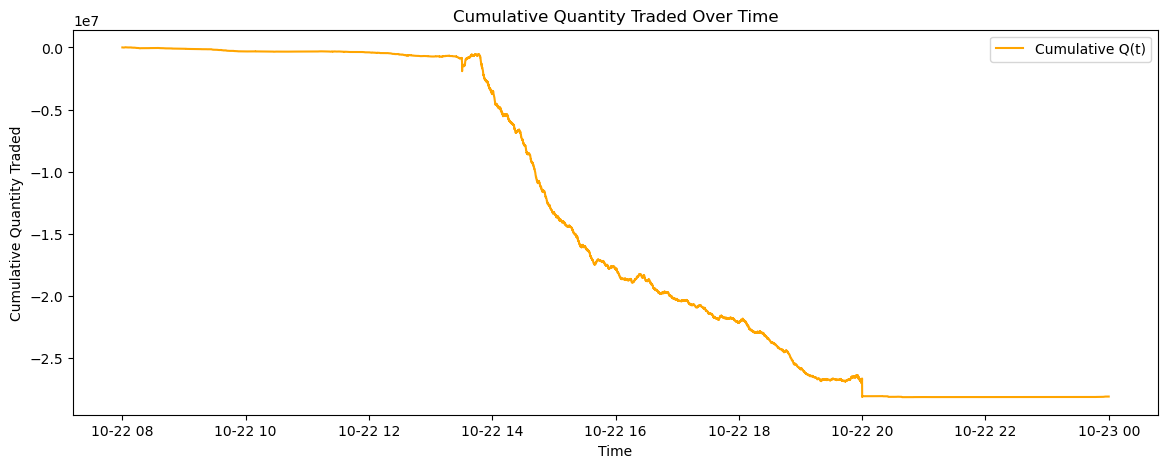

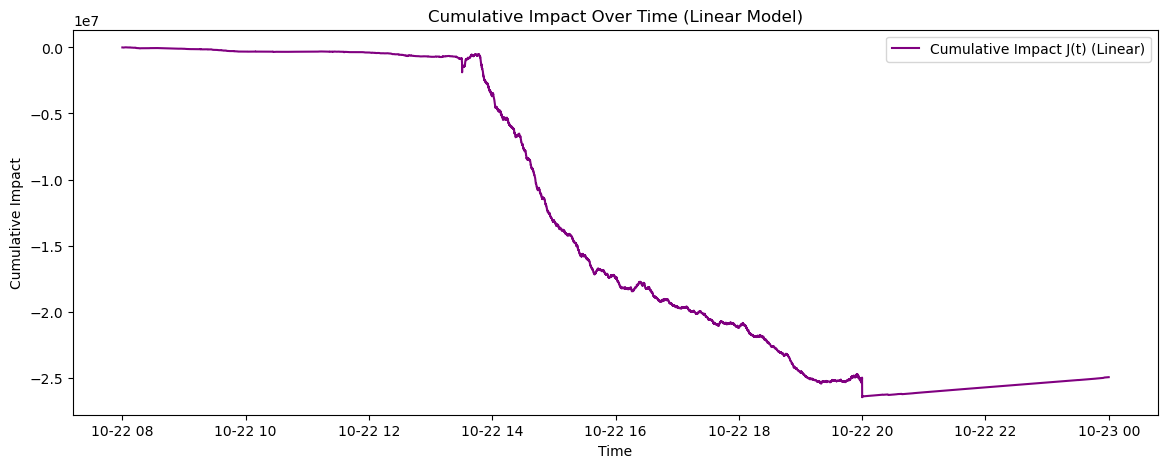

In [17]:

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(data['ts_event'], data['Price_Impact'], label='Actual Price Impact', color='blue')
plt.plot(data['ts_event'], data['I'], label='Simulated Price Impact (Linear)', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price Impact')
plt.title('Actual vs Simulated Price Impact (Linear Model)')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(data['ts_event'], data['Cumulative_Q'], label='Cumulative Q(t)', color='orange')
plt.xlabel('Time')
plt.ylabel('Cumulative Quantity Traded')
plt.title('Cumulative Quantity Traded Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(data['ts_event'], data['J'], label='Cumulative Impact J(t) (Linear)', color='purple')
plt.xlabel('Time')
plt.ylabel('Cumulative Impact')
plt.title('Cumulative Impact Over Time (Linear Model)')
plt.legend()
plt.show()
